In [2]:
import os
import pandas as pd
import polars as polars
from tqdm import tqdm
from params import const_en, const_ja
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

val_df = polars.read_csv(("TESTDATA/val_df.csv"),low_memory=False) #used
result_tdf = polars.read_csv(("TESTDATA/result_tdf.csv"),low_memory=False) #used
train_df = polars.read_csv(("TESTDATA/train_df.csv"),low_memory=False) #used
Const = const_en

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# Get rid of dupes columns
train_df = train_df.drop([col for col in train_df.columns if col.endswith('.1')])
val_df = val_df.drop([col for col in val_df.columns if col.endswith('.1')])
result_tdf = result_tdf.drop([col for col in result_tdf.columns if col.endswith('.1')])
def cast_columns_to_float(df,cols):
    for col in cols:
        if col in df.columns:
            df = df.with_columns(df[col].cast(polars.Float64).alias(col))
    return df
float_column = [
    Const.V_TARGET_OUTPUT, Const.V_BURNER_OUTPUT, Const.FEEDER1,
    Const.FEEDER2, Const.FEEDER3, Const.FEEDER4, Const.FEEDER5,
    Const.FEEDER6, Const.FEEDER7, Const.FEEDER8, Const.FEEDER9,
    Const.FEEDER10, Const.FEEDER11, Const.FEEDER12, Const.FEEDER13,
    Const.FEEDER14, Const.FEEDER15, Const.FEEDER16, Const.FEEDER17,
    Const.FEEDER18, Const.FEEDER19, Const.FEEDER20, Const.V_SET_TEMP,
    Const.V_AGG_TEMP, Const.V_BAG_TEMP
]
time_varying_unknown_reals = [
    Const.V_BAG_TEMP,
    Const.HUMIDITY,
    Const.TEMPERATURE,
    Const.BAG_INLET_TEMP_RISE_RATE,
    Const.V_AGG_TEMP,
    Const.AGG_TEMP_RISE_RATE
    ]
static_reals = [] #"Wetness of material (sand)"
time_varying_known_reals = [
    # "Sin_Hour",
    # "Cos_Hour",
    # "Sin_Month",
    # "Cos_Month",
    Const.TOTAL_SUPPLY,
    Const.FEEDER1,
    Const.V_SET_TEMP,
    Const.FEEDER2,
    Const.FEEDER3,
    Const.FEEDER4,
    Const.FEEDER5,
    Const.FEEDER7,
    Const.SUPPLY_TIME_ELAPSED,
    Const.COLD_AGG_TIME_ELAPSED
]
train_df = cast_columns_to_float(train_df, float_column)
val_df = cast_columns_to_float(val_df,float_column)
result_tdf = cast_columns_to_float(result_tdf, float_column)
train_df = train_df.to_pandas()
val_df = val_df.to_pandas()
result_tdf = result_tdf.to_pandas()

In [4]:
train_df["operation_id"] = train_df["operation_id"].astype(str)
# train_df["subsequence_id"] = train_df["subsequence_id"].astype(str)
result_tdf["operation_id"] = result_tdf["operation_id"].astype(str)

val_df["operation_id"] = val_df["operation_id"].astype(str)
# val_df["subsequence_id"] = val_df["subsequence_id"].astype(str)

print(len(result_tdf))
max_prediction_length = 60

training = TimeSeriesDataSet(
    train_df, #[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=Const.V_TARGET_OUTPUT,
    group_ids=["operation_id", "subsequence_id"],
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=300,
    min_prediction_length=max_prediction_length, # max_prediction_length ≤ shortest_series_length - max_encoder_length
    max_prediction_length=max_prediction_length, # max_encoder_length + max_prediction_length ≤ series_length
    static_categoricals=["operation_id"],
    static_reals=static_reals,
    # time_varying_known_categoricals=["DATE", "TIME"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=list(time_varying_known_reals),
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=list(time_varying_unknown_reals),
    target_normalizer=GroupNormalizer(
        groups=["operation_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders = {
        "operation_id": NaNLabelEncoder(add_nan=True),
        "subsequence_id": NaNLabelEncoder(add_nan=True),
    # Include all other categorical columns used
    },
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=True, stop_randomization=True)
test_dataset = TimeSeriesDataSet.from_dataset(training, result_tdf, predict=True,stop_randomization=False)
# validation.shape()

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False,batch_size=batch_size,num_workers=0)

632136


c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 3060 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__operation_id': '10', '__group_id__subsequence_id': 1}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 2}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 3}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 4}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 5}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 6}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 7}, {'__group_id__operation_id': '10', '__group_id__subsequence_id': 8}, {'__group_id__operation_id': '10', '__group_id__subsequence_id'

In [5]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:4

tensor(4.8479)

In [6]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Adam"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 17.0k


c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]
Learning rate set to 0.00023988329190194915
Restoring states from the checkpoint path a

suggested learning rate: 0.00023988329190194915


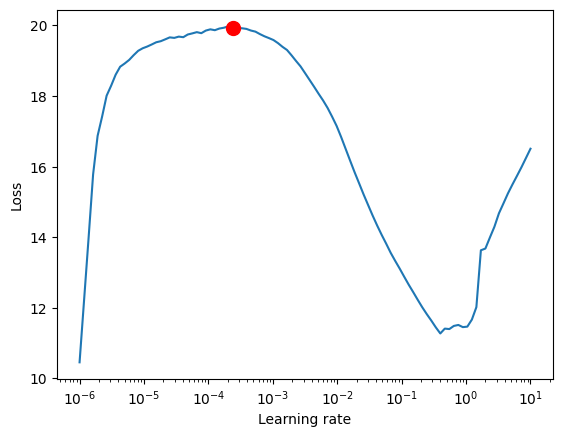

C:\Users\3562\AppData\Local\Temp\ipykernel_41156\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [7]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [8]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger(save_dir=os.getcwd(), name="logs_csv")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 36.2k


In [10]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 780    | train
3  | prescalers                         | ModuleDict                      | 320    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s, v_num=15, train_loss_step=0.639, val_loss=5.630, train_loss_epoch=0.565]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s, v_num=15, train_loss_step=0.639, val_loss=5.630, train_loss_epoch=0.565]


In [11]:
import pickle
# take ages
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import optuna
import statsmodels
print(optuna.__version__)
print(statsmodels.__version__)
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=2,
    max_epochs=10,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

4.5.0
0.14.5


[I 2025-09-22 11:10:58,621] A new study created in memory with name: no-name-03b120e9-d703-4bb2-b4c7-4c664042c6de
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),
c:\ProgramData\anaconda

{'gradient_clip_val': 0.49385769442084015, 'hidden_size': 56, 'dropout': 0.13810710111472838, 'hidden_continuous_size': 17, 'attention_head_size': 1, 'learning_rate': 0.004134720822793617}


In [12]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [13]:
# Predict all at once (no manual looping)
predictions = best_tft.predict(data=test_dataloader,return_x=True, return_index=True)
# if it's a Prediction object

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\tft_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


In [14]:
print(predictions.output)
pred = predictions.output
x_data = predictions.x
index = predictions.index
# y_true = predictions.y

# Extract actuals directly from dataloader
actuals_list = []
for _, y in test_dataloader:
    actuals_list.append(y[0])  # y[0] is your target
actuals = torch.cat(actuals_list).cpu()


print(len(pred))
print(len(x_data))
print(len(index))
print(index)
print(x_data)

# Put into DataFrame
duck = polars.DataFrame({
    "actuals": actuals.numpy(),
    "predictions": pred.numpy()
    # "index" : index.to_numpy().flatten()
})
index = polars.from_pandas(index)
for col in index.columns:
    duck = duck.with_columns(index[col].alias(col))

# CAST INTEGER
duck = duck.with_columns(
    polars.col("operation_id").cast(polars.Int64),
    polars.col("subsequence_id").cast(polars.Int64),
    polars.col("time_idx").cast(polars.Int64)
)

fox = duck.sort("operation_id")
fox = fox.to_pandas()
fox.to_csv("Fox.csv")
duck = duck.to_pandas()


duck.to_csv("Bduck.csv")


tensor([[2.0105e-08, 3.0446e-08, 3.7243e-08,  ..., 2.4058e+01, 2.4052e+01,
         2.4044e+01],
        [2.1012e-08, 2.6045e-08, 3.9157e-08,  ..., 2.4052e+01, 2.4044e+01,
         2.4035e+01],
        [2.3576e-08, 2.6339e-08, 4.0183e-08,  ..., 2.4045e+01, 2.4035e+01,
         2.4028e+01],
        ...,
        [2.6388e+01, 2.6443e+01, 2.6496e+01,  ..., 2.8126e+01, 2.8153e+01,
         2.8171e+01],
        [2.6441e+01, 2.6497e+01, 2.6559e+01,  ..., 2.8153e+01, 2.8171e+01,
         2.8181e+01],
        [2.6496e+01, 2.6561e+01, 2.6603e+01,  ..., 2.8171e+01, 2.8181e+01,
         2.8201e+01]])
4634
11
4634
      time_idx operation_id  subsequence_id
0            1           10              61
1            2           10              62
2            3           10              63
3            4           10              64
4            5           10              65
...        ...          ...             ...
4629       118            2             178
4630       119            2            

In [15]:
fox["time_idx_array"] = fox["time_idx"].apply(lambda t: np.arange(t, t + 60))
fox.to_csv("test_fox.csv")

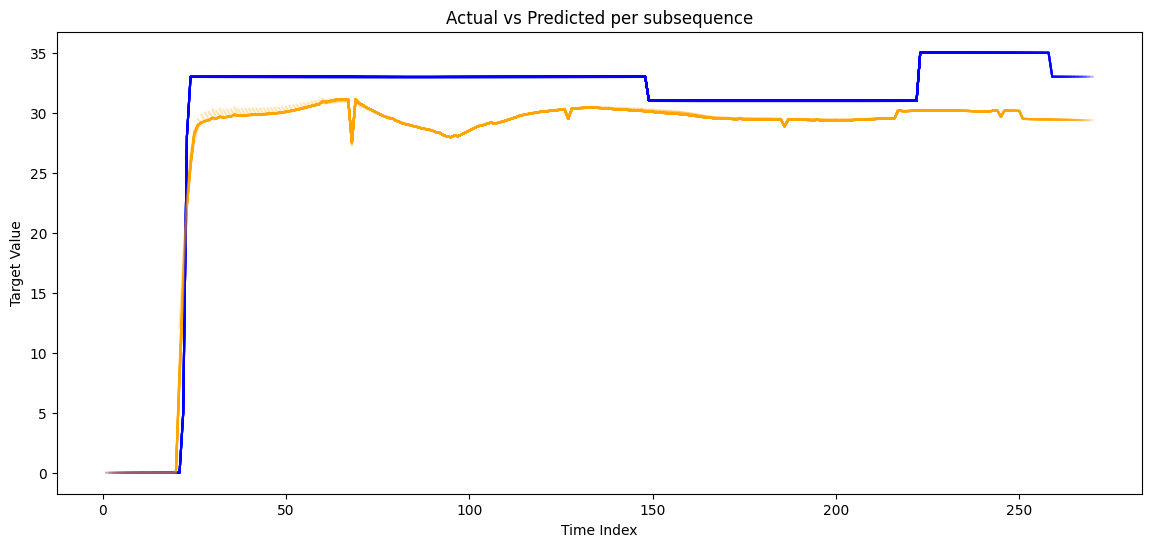

In [50]:
import matplotlib.pyplot as plt
import ast
import re
df_first_op = fox[fox['operation_id'] == 1]

import numpy as np
import re



# act_flatten=[]
# pred_flatten=[]
# time_flatten=[]
# # Fully flatten all rows into single arrays
# act_flatten = np.hstack(df_first_op['actuals'].values)
# pred_flatten = np.hstack(df_first_op['predictions'].values)
# time_flatten = np.hstack(df_first_op['time_idx_array'].values)
# Flatten each array in the 'actuals' column individually
# act_flatten = df_first_op['actuals'].apply(lambda arr: arr.flatten())
# pred_flatten = df_first_op['predictions'].apply(lambda arr: arr.flatten())
# time_flatten = df_first_op['time_idx_array'].apply(lambda arr: arr.flatten())

# print(act_flatten)


# test = polars.DataFrame({
#     "actuals": act_flatten,
#     "predictions": pred_flatten,
#     "index" : time_flatten
# })
# test = test.to_pandas()
# test.to_csv("testy.csv")
plt.figure(figsize=(14,6))
# Loop over each row / subsequence and plot as a separate line
for i, row in df_first_op.iterrows():
    plt.plot(row['time_idx_array'], row['actuals'], color='blue', alpha=0.3)   # actuals
    plt.plot(row['time_idx_array'], row['predictions'], color='orange', alpha=0.3)  # predictions

plt.title("Actual vs Predicted per subsequence")
plt.xlabel("Time Index")
plt.ylabel("Target Value")
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

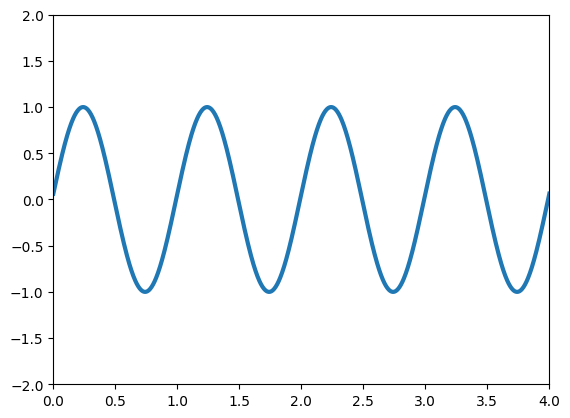

In [60]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation 
 
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
 
# marking the x-axis and y-axis
axis = plt.axes(xlim =(0, 4), 
                ylim =(-2, 2)) 

# initializing a line variable
line, = axis.plot([], [], lw = 3) 
 
# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([], [])
    return line,
 
def animate(i):
    x = np.linspace(0, 4, 1000)
 
    # plots a sine graph
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    
    return line,
 
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 200, interval = 20, blit = True)

 
anim.save('continuousSineWave.mp4', 
          writer = 'ffmpeg', fps = 30)

In [ ]:
# LAST PREDICTION ONLY .

# print(actuals[83])
# print(len(actuals))
# actuals_last = []
# predictions_last = []
# # Get t step = 5

# fox['actuals'] = fox['actuals'].apply(
#     lambda x: x[max_prediction_length-1] if isinstance(x, (list, tuple, np.ndarray)) else x
# )

# fox['predictions'] = fox['predictions'].apply(
#     lambda x: x[max_prediction_length-1] if isinstance(x, (list, tuple, np.ndarray)) else x
# )

# fox.to_csv("Updated_Fox.csv", index=False)
# print("Replaced arrays with last timestep safely")



tensor([32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
        32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
        32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
        32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
        32., 32., 32., 32.])
4634
Replaced arrays with last timestep safely


In [ ]:
# ROLLING FORECAST

# convert "string arrays" → real np.float32 arrays
df["actuals"] = df["actuals"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
df["predictions"] = df["predictions"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# sanity check
print(type(df["actuals"].iloc[0]), df["actuals"].iloc[0].shape)
print(df["actuals"].iloc[0][:10])  # first 10 values

In [ ]:
# MAE over the prediction horizon
y_true = np.stack(df["actuals"].values)       # shape (n_windows, 60)
y_pred = np.stack(df["predictions"].values)   # shape (n_windows, 60)
# print(y_pred)
mae_per_horizon = np.mean(np.abs(y_true - y_pred), axis=0)

plt.figure(figsize=(10,5))
plt.plot(range(1, 61), mae_per_horizon, marker="o")
plt.xlabel("Forecast horizon (steps ahead)")
plt.ylabel("MAE")
plt.title("Forecast error vs horizon")
plt.show()
